In [37]:
import numpy as np
import matplotlib.pyplot as plt

# we set a seed to make the results reproducible
np.random.seed(32)


# Gaussian Processes - Exercise Session 1

## Relationship between linear models and conditional Gaussian distribution

In this exercise session, you are going to learn the relationship between the predictions given by a linear model and the mean estimate given by a conditional Gaussian distribution. We will derive both formula step-by-step and you should implement them in Python.


### Dataset creation

We are going to create a toy dataset $D=\{(\mathbf{x_1},y_1),...(\mathbf{x_n},y_n)\}$, where $\mathbf{x} \in \mathbb{R}^3$ and $y \in \mathbb{R}$. The $\mathbf{x}$ is created in the following way:


1.   First we sample a number in $[0,1]$ for each dimension
2.   Then we multiply each dimension with a random integer in the range $[1,20]$

This way, we now have random $x$'s with very different values. Since we want to have a bias term in our linear model, we use the trick of adding a of 1 in front of our $\mathbf{x} \in D$.

The next step is to generate the $y$ for each $\mathbf{x}$. We have to define the real weights vector $\mathbf{w}\in \mathbb{R}^4$ and then compute 
$$y = \mathbf{w}^T \mathbf{x} + \epsilon$$
where $\epsilon$ is the zero-mean and unit variance Gaussian noise.

At this point, we have our datset $D$ ready. We will split it in a training set $\mathbf{X}$ and a test set $\mathbf{X_*}$ (we here will adhere to a typical setting were 80% of the data goes into the training set and the remaining 20% will be reserved for testing. 


In [38]:
## we have to create our dataset
real_weights = np.array([3.24, 1.27, -4.52, 1.75])

# number of observations
N = 100
# dimension of X
d = 3
X = np.random.rand(N,d) * np.random.randint(1,20,(N,d)) # Nxd matrix

# we add the bias term adding a column of 1 in front
# of our matrix X
X = np.hstack((np.ones((N,1)), X)) # Nx(d+1)

# compute the y's for each example
# noisy --> add random noise
y = real_weights @ X.T + np.random.randn(N)# N

# now we can split the dataset in training and test set
Xtrain = X[:80,:]
ytrain = y[:80]

Xtest = X[80:,:]
ytest = y[80:]

print('Safety check: sizes')
print(Xtrain.shape)
print(ytrain.shape)
print(Xtest.shape)
print(ytest.shape)

Safety check: sizes
(80, 4)
(80,)
(20, 4)
(20,)


### Conditional Gaussian

We start by assuming that

$$\begin{bmatrix} y \\ \mathbf{x} \end{bmatrix} \sim \mathcal{N}\left(\mathbf{0}, \begin{bmatrix} \Sigma_{yy} & \Sigma_{yx} \\ \Sigma_{xy} & \Sigma{xx} \end{bmatrix} \right) $$

where $\Sigma_{yy} \in \mathbb{R}$ and $\Sigma_{yy} = \sigma_{y}^2$, i.e. it is the variance of the $y$ because $y \in \mathbb{R}$. $\Sigma_{xx}$ is instead the covariance matrix related to the input vectors $\mathbf{x}$. 

<font color='lightblue'>Tasks:</font>

<font color='lightblue'>**1-** Since we are assuming a zero-mean distribution, we should center or standardize our data. </font>

<font color='lightblue'>**2-** In the distribution above, we are considering the distribution of a vector created by concatenating the training target $y_i$ to each training input $\mathbf{x}_i$. Have a look at the python function `numpy.hstack` to implement this step.</font>

<font color='lightblue'>**3-** At this point you can compute the sample mean and the sample covariance of this distribution. Be careful and read the documentation of `np.cov`.</font>

In [39]:
# we assume that the traning data (y,x) ~ N(0,\Sigma)
# to have 0 mean we have to center the data

## WRITE THE CODE TO CENTER THE Xs
Xtrain_mean = np.mean(Xtrain, axis=0)
Xtrain = Xtrain-Xtrain_mean

## WRITE THE CODE TO CENTER THE Xs
ytrain_mean = np.mean(ytrain)
ytrain = ytrain-ytrain_mean

# create arrays [y,x1,x2,...,xd] for each array
dataset = np.column_stack((ytrain, Xtrain))

print('Safety check') # you should get (80, 5) as shape
print(dataset.shape)


# COMPUTE THE SAMPLE MEAN AND SAMPLE COVARIANCE
mu_dataset = np.mean(dataset, axis=0)
cov_dataset = np.cov(dataset, rowvar=False) # you should get a dxd matrix

Safety check
(80, 5)


At this point we have the distribution of $\begin{bmatrix} y \\ \mathbf{x} \end{bmatrix}$ defined above. However, we are interested in the conditional probability $y|\mathbf{x}$. We know from the lecture that the conditional distribution of a Gaussian distribution is still a Gaussian distribution. 

Therefore we are looking for:

$$ y | \mathbf{x} \sim \mathcal{N}(\mathbf{\mu}_{y|\mathbf{x}}, \Sigma_{y|\mathbf{x}})$$

where

$$\mathbf{\mu}_{y|\mathbf{x}} = \mu_{y} + \Sigma_{yx}\Sigma_{xx}^{-1}(\mathbf{x}-\mu_{x}) $$

$$\Sigma_{y|\mathbf{x}} = \Sigma_{yy} - \Sigma_{yx}\Sigma_{xx}^{-1}\Sigma_{xy}$$

Since we have centered our data, we have that both $\mu_{y} = 0$ and $\mu_{x}= 0$. Therefore, the equation for computing the $\mathbf{\mu}_{y|\mathbf{x}}$ becomes easier:

$$\mathbf{\mu}_{y|\mathbf{x}} = \Sigma_{yx}\Sigma_{xx}^{-1}\mathbf{x} $$

We are mostly interested in the mean of this distribution, because it is the one that give us the mean estimate for every input $\mathbf{x}$. Indeed. if we look at the definition of the mean we can see that it is a linear function of the inputs $\mathbf{x}$. For simplicity you can write it as $\mathbf{\mu}_{y|\mathbf{x}} = \mathbf{c} \mathbf{x}$, where $\mathbf{c}=\Sigma_{yx}\Sigma_{xx}^{-1}$. As we are going to see later, this is really similar to what we get when we are using a linear model for predictions. 


<font color='lightblue'>Tasks:</font>

<font color='lightblue'> **1**- Starting from the mean and covariance you have computed at the previous step, you should compute the vector $\mathbf{c}=\Sigma_{yx}\Sigma_{xx}^{-1}$, because if we know its value, we are able to compute the value of the mean $\mathbf{\mu}_{y|\mathbf{x}}^*$ for every test input vectors $\mathbf{x}_*$. To compute the inverse of a matrix you can use `np.linalg.pinv`.</font>

In [40]:
display(cov_dataset)

array([[343.24799378,   0.        ,  32.50261211, -58.70607735,
         22.79886234],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [ 32.50261211,   0.        ,  21.44406901,  -0.76748204,
          1.12534035],
       [-58.70607735,   0.        ,  -0.76748204,  13.14917366,
          0.59349468],
       [ 22.79886234,   0.        ,   1.12534035,   0.59349468,
         14.09736946]])

In [41]:
# we are interested in p(y|x1,..xd) which is Gaussian given by
# mu_yx = Sigmayx Simgaxx^-1 x

# SEPARATE ALL THE PIECES IN THE COVARIANCE MATRIX
Sigma_yy = cov_dataset[0, 0]
Sigma_yx = cov_dataset[0, 1:]
Sigma_xy = cov_dataset[1:, 0]
Sigma_xx = cov_dataset[1:, 1:]

print('Safety check covariance')
print(Sigma_yy.shape)
print(Sigma_xy.shape)
print(Sigma_yx.shape)
print(Sigma_xx.shape)

## 

# COMPUTE THE INVERSE AND THEN DO THE MATRIX MULTIPLICATION \Sigmayx\Sigmaxx^-1
C = Sigma_yx @ np.linalg.pinv(Sigma_xx)

print('Safety check')
print(C.shape)
print('The C')

Safety check covariance
()
(4,)
(4,)
(4, 4)
Safety check
(4,)
The C


### Linear models

<font color='grey'>  Notation alert! We are going to write summations in matrix notation, therefore you should be comfortable with using vectors and matrices. </font>


Here we are going to derive again the Normal Equation that you have already seen in your Machine Learning course. In regression, we usually try to learn a model of this form:
$$y = \mathbf{w}^T\mathbf{x}$$
where $\mathbf{w}=[w_0, w_1,\dotsc,w_D]$ and $\mathbf{x} = [1, x_0, x_1, \dotsc, x_D]$.

Given a dataset that contains $N$ training examples $(\mathbf{x}_i,y_i)_{i=1,\dotsc,N}$, we learn the weigths or parameters of the model $\mathbf{w}$ by minimizing the Mean-Squared Error of the dataset given by
$$ E(\mathbf{w}) = \frac{1}{2} \sum_{n=1}^{N}(y_n - \mathbf{w}^T\mathbf{x}_n)^2$$

We can rewrite $E(\mathbf{w})$ as
\begin{align}
E(\mathbf{w}) &= \frac{1}{2} \sum_{n=1}^{N}(y_n - \mathbf{w}^T\mathbf{x}_n)^2 \\
              &= \frac{1}{2} \left\| \mathbf{X}\mathbf{w} - \mathbf{y} \right\|^2 \\
              &= \frac{1}{2} (\mathbf{X}\mathbf{w} - \mathbf{y})^T(\mathbf{X}\mathbf{w} - \mathbf{y}) \\
              &= \frac{1}{2} \mathbf{w}^T\mathbf{X}^T\mathbf{X}\mathbf{w} - \frac{1}{2}\mathbf{w}^T\mathbf{X}^T\mathbf{y} - \frac{1}{2} \mathbf{y}^T\mathbf{X}\mathbf{w} + \frac{1}{2} \mathbf{y}^T\mathbf{y} \\
              &= \frac{1}{2} \mathbf{w}^T\mathbf{X}^T\mathbf{X}\mathbf{w} - \mathbf{w}^T\mathbf{X}^T\mathbf{y} + \frac{1}{2} \mathbf{y}^T\mathbf{y}
\end{align}

where in the last line we use the fact that $(\mathbf{X}\mathbf{w})^T \mathbf{y} = \mathbf{y}^T(\mathbf{X}\mathbf{w})$ because the inner product is commutative and the fact that $(\mathbf{X}\mathbf{w})^T=\mathbf{w}^T\mathbf{X}^T$.

Since we want to find the weights $\mathbf{w}$ that minimize $E(\mathbf{w})$, from calculus we know that to solve this problem we can take the gradient of $E(\mathbf{w})$, and then set it to zero and solve the resulting system. 
$$\nabla E(\mathbf{w}) = \begin{bmatrix} \frac{\partial E}{\partial w_0}\\ \frac{\partial E}{\partial w_1}\\ \vdots \\ \frac{\partial E}{\partial w_D} \end{bmatrix} = 0$$ 

Two compute the gradient we use two results that are important to know:
$$ f(\mathbf{w}) = \mathbf{w}^T\mathbf{A}\mathbf{w} \implies \nabla f(\mathbf{w}) = 2 \mathbf{A}\mathbf{w}$$
$$ f(\mathbf{w}) = \mathbf{a}^T\mathbf{w}  \implies \nabla f(\mathbf{w}) = \mathbf{a}$$

Therefore we can see that the gradient of $E(\mathbf{w})$ is given by:
$$\nabla E(\mathbf{w}) = \mathbf{X}^T \mathbf{X} \mathbf{w} - \mathbf{X}^T\mathbf{y} $$
and if we put this to zero we get
\begin{align}
\mathbf{X}^T \mathbf{X} \mathbf{w} - \mathbf{X}^T\mathbf{y} = 0 \\
\mathbf{X}^T \mathbf{X} \mathbf{w} = \mathbf{X}^T\mathbf{y} \\
\mathbf{w}  = (\mathbf{X}^T \mathbf{X})^{-1}\mathbf{X}^T\mathbf{y} 
\end{align}

<font color='lightblue'> Tasks:</font>

<font color='lightblue'> **1**- You should code the normal equation in Python. The easiest way to compute it is to write all the matrix multiplication as shown in the formula. Remember, if you want to compute the inverse of a matrix use `numpy.linalg.pinv`. </font>

<font color='lightblue'> (There are other ways you can maybe implement the normal equation, but for this exercise we required you to use the easiest one. You maybe notice that you are trying to solve a linear system, therefore you would try to use `numpy.linalg.solve`. However, in case our system is either over or underconstrained this method will return an error. In those cases you can consider `numpy.linalg.lstsq` which will return the solution that minimizes the squared error.) </font>



In [42]:
# WRITE THE NORMAL EQUATION

#w = np.linalg.pinv(X.T@X)@X.T@y
w = np.linalg.pinv(Xtrain.T@Xtrain)@Xtrain.T@ytrain

print('The weights obtained by solving the normal equation are:', w)

The weights obtained by solving the normal equation are: [ 0.          1.26636126 -4.46762863  1.70423914]


### Predictions

You have already seen in previous courses how to compute the prediction $y_*$ for a test example $\mathbf{x}_*$:
$$y_* = \mathbf{w}^T \mathbf{x}_*$$
using the weights you have computed in the previous step.

Maybe you have not seen before that you can use multivariate Gaussian distribution to make predictions. For predicting the target $y_*$ for a particular test input $x_*$ you should use the conditional Gaussian distribution $y_*|\mathbf{x}_*$, that you have computed above. Indeed, you want to compute the distribution of the possible targets $y_*$ given the test input $x_*$. A good estimate of $y_*$ would be the mean of this distribution, therefore you should compute:
$$y_* = \mu_{y_*|\mathbf{x}_*} = \Sigma_{yx}\Sigma_{xx}^{-1}\mathbf{x}_*$$
where the $\Sigma_{yx}$ and $\Sigma_{xx}$ are those you have calculated from the training set.

<font color='lightblue'>Tasks: </font>

<font color='lightblue'> **1**- For each test point, you should compute the prediction given by the linear model and the mena of the conditional distribution, and plot it. What do you notice? 

**N.B**: Remember that every modifications you did in the training set should be done also in the test set. This means that  you should center each test set (both the input $\mathbf{x}_*$ and the true target $y$ using the means you have computed in the training set!) </font>



In [43]:
# CENTER THE TEST EXAMPLES
Xtest = Xtest - Xtrain_mean
ytest = ytest - ytrain_mean

# COMPUTE THE PREDICTION USING THE LINEAR MODEL
yhat = Xtest @ w

# COMPUTE THE MEAN GIVEN BY THE CONDITIONAL GAUSSIAN
mu_hat = Xtest @ C

# PRINT THE RESULTS
columns = ('Example no.', 'y (true)', 'y_hat (lin. reg.)', 'mu(y|x) (cond. mean)')
print('    '.join(columns))
for i, (y, yh, ym) in enumerate(zip(ytest, yhat, mu_hat)):
    print('{:11d}    {:8.2f}    {:17.2f}    {:20.2f}'.format(i+1, y, yh, ym))

Example no.    y (true)    y_hat (lin. reg.)    mu(y|x) (cond. mean)
          1       12.88                12.54                   12.54
          2       -7.98                -9.02                   -9.02
          3      -34.22               -34.70                  -34.70
          4       19.27                19.45                   19.45
          5       -1.26                -0.49                   -0.49
          6      -38.13               -39.66                  -39.66
          7       15.70                13.94                   13.94
          8       -6.45                -8.91                   -8.91
          9       13.65                10.57                   10.57
         10        1.72                 1.43                    1.43
         11       -1.63                -1.10                   -1.10
         12        9.19                 9.32                    9.32
         13        2.49                 2.14                    2.14
         14       20.84           

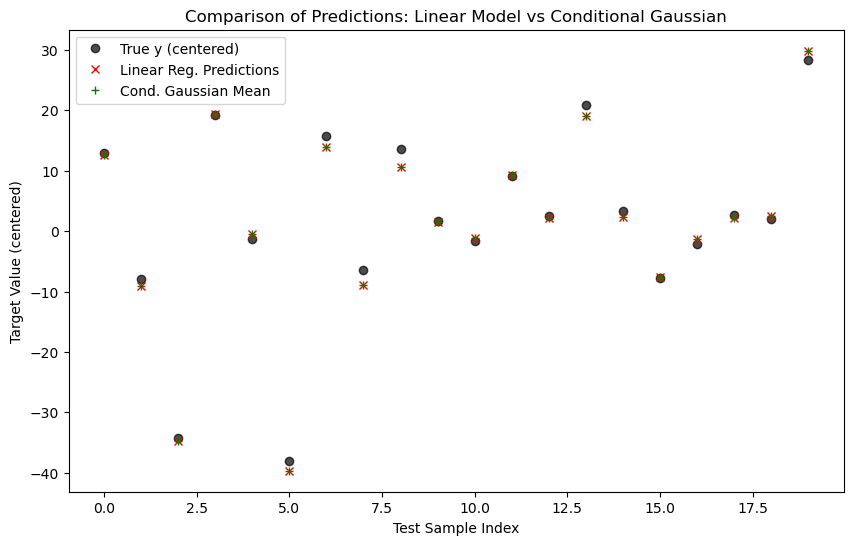

In [44]:
plt.figure(figsize=(10, 6))

# Plot true y
plt.plot(ytest, 'ko', label='True y (centered)', alpha=0.7)

# Plot linear-regression predictions
plt.plot(yhat, 'rx', label='Linear Reg. Predictions')

# Plot conditional Gaussian predictions
plt.plot(mu_hat, 'g+', label='Cond. Gaussian Mean')

plt.title("Comparison of Predictions: Linear Model vs Conditional Gaussian")
plt.xlabel("Test Sample Index")
plt.ylabel("Target Value (centered)")
plt.legend()
plt.show()


### Why do we get this result?

<font color='lightblue'> From the results you get, what can you notice? Try to think at the possible reasons why you observe this findings! </font>